Install libraries

In [ ]:
#Need to install if not installed yet
!pip install matplotlib
!pip install scipy
!pip install sklearn
!pip install pandas
!pip install seaborn
!pip install haversine
!pip install -U wxPython 


Import libraries

In [1]:
import multiprocessing as mp

import matplotlib.pyplot as plt
import numpy as np

from scipy import signal
from scipy.stats import uniform
from scipy.stats import norm

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix
import csv

import pandas as pd
import time
import os
from datetime import datetime, timedelta

import seaborn as sn
import requests
import json

import haversine as hs

import wx

READ DATA

#Read Data from February
header_CC=["codigoSerial", "fecha", "hora", "fechaHora", "temperatura", "humedad_relativa", "pm1_df", "pm10_df", "pm25_df", "pm1_nova", "pm10_nova", "pm25_nova", "calidad_temperatura", "calidad_humedad_relativa", "calidad_pm1_df", "calidad_pm10_df", "calidad_pm25_df", "calidad_pm1_nova", "calidad_pm10_nova", "calidad_pm25_nova"]
datatypes_CC={"codigoSerial":np.uint16, "temperatura":np.float16, "humedad_relativa":np.float16, "pm1_df":np.float32, "pm10_df":np.float32, "pm25_df":np.float32, "pm1_nova":np.float32, "pm10_nova":np.float32, "pm25_nova":np.float32}
df_CC = pd.read_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/SIATA_CS/SplitDatosCC/Samples/"+"February.csv", header=None, names=header_CC, usecols=header_CC , dtype=datatypes_CC,parse_dates=["fecha","hora","fechaHora"])

#Data includes January, February and March
header_SS=["Fecha_Hora","codigoSerial","pm25","calidad_pm25","pm10","calidad_pm10"]
datatypes_SS={"codigoSerial":np.uint16,"pm25":np.float32,"pm10":np.float32}
df_SS = pd.read_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/SIATA Stations/PM/"+"SS_PM.csv", header=None,names=header_SS, usecols=header_SS , dtype=datatypes_SS,parse_dates=["Fecha_Hora"])


grouped=df_CC.groupby(df_CC.codigoSerial)
CC={}
print("Citizen Scientist: ", sorted(list(df_CC.codigoSerial.unique())))
for i in df_CC.codigoSerial.unique():
    CC[i] = grouped.get_group(i).sort_values(by=['fechaHora'],ignore_index=True)
del df_CC

grouped=df_SS.groupby(df_SS.codigoSerial)
SS={}
print("Siata Stations: ", list(df_SS.codigoSerial.unique()))
for j in df_SS.codigoSerial.unique():
    SS[j] = grouped.get_group(j).sort_values(by=['Fecha_Hora'],ignore_index=True)
del df_SS
del grouped

READ DISTANCES

In [35]:
datatypesDistances={"codigoSerial_CC":np.uint16,"codigoSerial_ES":np.uint16,"Distancia_a_ES":np.float16,"codigoSerial_ES2":np.uint16}
Distances = pd.read_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/Distances and positions/Distancias_2.csv", header=0, dtype=datatypesDistances,index_col="codigoSerial_CC")


DQ CALCULATIONS

In [4]:
inicio="2020-02-01 00:00:00"
fin=   "2020-02-29 23:59:00"
nube=0
contador=0

acc_vs_dis=[]
missing_data_df=[]
missing_data_nova=[]

df_accur = pd.DataFrame(columns =['codigoSerial', 'dist', 'acc_nova', 'acc_df'])
df_comple = pd.DataFrame(columns =["codigoSerial","completeness_df","completeness_nova","completeness_group_df","completeness_group_nova"])
df_preci = pd.DataFrame(columns =["codigoSerial","precision_df","precision_nova","precision_group_df","precision_group_nova"])
df_uncer = pd.DataFrame(columns =["codigoSerial","uncertainty","uncertainty_group"])
df_conco = pd.DataFrame(columns =["codigoSerial","concordance_df_nova","concordance_df_siata","concordance_df_hum","concordance_df_temp","concordance_nova_siata","concordance_nova_hum","concordance_nova_temp"])

for nube in CC.keys():
    contador+=1
    CC[nube]["v_pm25"] = np.nan
    CC[nube]["alpha_df"] = np.nan
    CC[nube]["alpha_nova"] = np.nan
    #del df_window
    df_window=CC[nube][(CC[nube]['fechaHora'] >= inicio) & (CC[nube]['fechaHora'] <= fin)]
    
    #Remove outliers that are out of range, from documentation both nova and df range of measurements are [0,999]

    df_window=df_window.copy()
    df_window.loc[df_window["pm25_nova"]>999,"pm25_nova"]=np.nan
    df_window.loc[df_window["pm25_nova"]<0,"pm25_nova"]=np.nan
    df_window.loc[df_window["pm25_df"]>999,"pm25_df"]=np.nan
    df_window.loc[df_window["pm25_df"]<0,"pm25_df"]=np.nan
    
    #Remove data above the whiskers of the boxplot
    Q1 = df_window['pm25_df'].quantile(0.25)
    Q3 = df_window['pm25_df'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 
    df_window.loc[df_window["pm25_df"]>=Q3 + 1.5 *IQR,"pm25_df"]=np.nan
    
    Q1 = df_window['pm25_nova'].quantile(0.25)
    Q3 = df_window['pm25_nova'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 
    df_window.loc[df_window["pm25_nova"]>=Q3 + 1.5 *IQR,"pm25_nova"]=np.nan
    
    ref_date_range = pd.date_range(inicio, fin, freq='1Min')
    ref_date_range = pd.DataFrame(ref_date_range,columns=["ref_fechaHora"])
    
    #Hourly mean
    df_window['pm25_nova_ave']=np.nan
    df_window['pm25_df_ave']=np.nan
    #Hourly standar deviation
    df_window['pm25_nova_std']=np.nan
    df_window['pm25_df_std']=np.nan
    #Hourly uncertainty
    df_window['pm25_unc']=np.nan
    
    for ts in df_window['fechaHora']:
        if ts==ts.ceil('60min'):
            window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < (ts+timedelta(minutes = 1)).ceil('60min'))]
            
        else:
            window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < ts.ceil('60min'))]
        #print("Timestamp: ",ts,", Floor:",ts.floor('60min'),", Ceil:",ts.ceil('60min'),window['pm25_nova'].mean())
        #print(window['pm25_nova'])
        df_window.loc[df_window["fechaHora"]==ts,'pm25_nova_ave']=window['pm25_nova'].mean()
        df_window.loc[df_window["fechaHora"]==ts,'pm25_df_ave']=window['pm25_df'].mean()
        
        df_window.loc[df_window["fechaHora"]==ts,'pm25_nova_std']=100*(window['pm25_nova'].std()/window['pm25_nova'].mean())
        df_window.loc[df_window["fechaHora"]==ts,'pm25_df_std']=100*(window['pm25_df'].std()/window['pm25_df'].mean())
        
        df_window.loc[df_window["fechaHora"]==ts,'pm25_unc']=\
        100*np.sqrt((window.pm25_df-window.pm25_nova).pow(2).mean()/2)/((window.pm25_df+window.pm25_nova).mean()/2)
        
    del window

    prec_df=df_window.pm25_df_std.mean()
    prec_nova=df_window.pm25_nova_std.mean()
    uncer_df=df_window.pm25_unc.mean()
    
        
    df_preci=df_preci.append({"codigoSerial":nube,"precision_df":prec_df,"precision_nova":prec_nova}, ignore_index = True)
    print("%d. Nube: %d, Overall relative (Precision) Standard Deviation."%(contador,nube))
    
    df_uncer=df_uncer.append({"codigoSerial":nube,"uncertainty":uncer_df}, ignore_index = True)
    print("%d. Nube: %d, Overall relative Uncertainty BS, "%(contador,nube))
    
    Closest_Station=Distances.codigoSerial_ES.loc[nube]    
    if Closest_Station in SS.keys():
        #Clean values out of range
        SS[Closest_Station].loc[SS[Closest_Station]["pm25"]<=0,"pm25"]=np.nan
        for time in df_window.fechaHora:
            
            idx=SS[Closest_Station].Fecha_Hora.searchsorted(time,side="right")
            #print(idx, SS[Closest_Station].Fecha_Hora.loc[idx], time)
            v=SS[Closest_Station].loc[idx,"pm25"]
            df_window.loc[df_window.fechaHora == time,"v_pm25"]=v
            vm=df_window.loc[(df_window.fechaHora == time),"pm25_df_ave"]
            #print(time," : ",vm.values[0],"________",SS[Closest_Station].Fecha_Hora.loc[idx]," : ",v)
            df_window.loc[df_window.fechaHora == time,"alpha_df"]=100*abs(vm-v)/v
            vm=df_window.loc[(df_window.fechaHora == time),"pm25_nova_ave"]
            df_window.loc[df_window.fechaHora == time,"alpha_nova"]=100*abs(vm-v)/v
        
        df_accur=df_accur.append({'codigoSerial':nube, 'dist':Distances.loc[nube,"Distancia_a_ES"], 'acc_df':df_window.alpha_df.mean(), 'acc_nova':df_window.alpha_nova.mean()}, ignore_index = True)
        print("%d. Nube: %d, Accuracy," %(contador, nube))
    
    ref_date_range = pd.date_range(inicio, fin, freq='1Min')
    ref_date_range = pd.DataFrame(ref_date_range,columns=["ref_fechaHora"])

    
    #Check for any missing date
    missing_dates = ref_date_range.loc[~ref_date_range.ref_fechaHora.isin(df_window.fechaHora),"ref_fechaHora"]

    #Add missing date rows
    for missing in missing_dates:
        df_window=df_window.append({"codigoSerial":nube,"fechaHora":missing}, ignore_index = True)
    
    #Check for any missing date
    missing_dates = ref_date_range.loc[~ref_date_range.ref_fechaHora.isin(df_window.fechaHora),"ref_fechaHora"]
    
    #Check for missing data
    missing_data_df=np.count_nonzero(np.isnan(df_window['pm25_df']))
    missing_data_nova=np.count_nonzero(np.isnan(df_window['pm25_nova']))
    comp_df=100*(1-missing_data_df/np.size(df_window.pm25_df))
    comp_nova=100*(1-missing_data_nova/np.size(df_window.pm25_nova))
    
    
    if comp_df<75:
        group_df=0
    elif 75<=comp_df:
        group_df=1
    
    if comp_nova<75:
        group_nova=0
    elif  75<=comp_nova:
        group_nova=1     
        
    df_comple=df_comple.append({"codigoSerial":nube,"completeness_df":comp_df,"completeness_nova":comp_nova,"completeness_group_df":group_df,"completeness_group_nova":group_nova}, ignore_index = True)
    
    print("%d. Nube: %d, Completeness." %(contador,nube))
    
    corr_df = df_window.loc[:,["pm25_df","pm25_nova","v_pm25","temperatura","humedad_relativa"]].corr().iloc[0].abs()
    corr_nova = df_window.loc[:,["pm25_df","pm25_nova","v_pm25","temperatura","humedad_relativa"]].corr().iloc[1].abs()
  
    
        
    df_conco=df_conco.append({"codigoSerial":nube,"concordance_df_nova":corr_df.pm25_nova,
                              "concordance_df_siata":corr_df.v_pm25,"concordance_df_hum":corr_df.humedad_relativa,"concordance_df_temp":corr_df.temperatura,
                              "concordance_nova_siata":corr_nova.v_pm25,"concordance_nova_hum":corr_nova.humedad_relativa,"concordance_nova_temp":corr_nova.temperatura}, 
                             ignore_index = True)
    
    print("%d. Nube: %d, Overall concordance, "%(contador,nube))

1. Nube: 220, Overall relative (Precision) Standard Deviation.
1. Nube: 220, Overall relative Uncertainty BS, 
1. Nube: 220, Accuracy,
1. Nube: 220, Completeness.
1. Nube: 220, Overall concordance, 
2. Nube: 1, Overall relative (Precision) Standard Deviation.
2. Nube: 1, Overall relative Uncertainty BS, 
2. Nube: 1, Accuracy,
2. Nube: 1, Completeness.
2. Nube: 1, Overall concordance, 
3. Nube: 192, Overall relative (Precision) Standard Deviation.
3. Nube: 192, Overall relative Uncertainty BS, 
3. Nube: 192, Accuracy,
3. Nube: 192, Completeness.
3. Nube: 192, Overall concordance, 
4. Nube: 261, Overall relative (Precision) Standard Deviation.
4. Nube: 261, Overall relative Uncertainty BS, 
4. Nube: 261, Accuracy,
4. Nube: 261, Completeness.
4. Nube: 261, Overall concordance, 
5. Nube: 262, Overall relative (Precision) Standard Deviation.
5. Nube: 262, Overall relative Uncertainty BS, 
5. Nube: 262, Accuracy,
5. Nube: 262, Completeness.
5. Nube: 262, Overall concordance, 
6. Nube: 104, O

In [5]:
df_conco.to_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/df_conco.csv",index=False)
df_comple.to_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/df_comple.csv",index=False)
df_accur.to_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/df_accur.csv",index=False)
df_uncer.to_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/df_uncer.csv",index=False)
df_preci.to_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/df_preci.csv",index=False)

COMPLETENESS

In [8]:
df_comple = pd.read_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/df_comple.csv", header=0)
print(df_comple.head(2))

dic_df={}
dic_nova={}
grouped_df=df_comple.groupby(df_comple.completeness_group_df)
grouped_nova=df_comple.groupby(df_comple.completeness_group_nova)
for i in df_comple.completeness_group_df.unique():
    dic_df[i]=grouped_df.get_group(i).sort_values(by=['codigoSerial'],ignore_index=True).codigoSerial.tolist()

for i in df_comple.completeness_group_nova.unique():
    dic_nova[i]=grouped_nova.get_group(i).sort_values(by=['codigoSerial'],ignore_index=True).codigoSerial.tolist()

print("Completeness < 75%: Group 0, Completeness >= 75%: Group 1")
print("DF sensors",dic_df)
print("Nova sensors",dic_nova)
print(len(dic_df[1]),len(dic_nova[1]))

   codigoSerial  completeness_df  completeness_nova  completeness_group_df  \
0         220.0        35.536398          34.238506                    0.0   
1           1.0        89.578544          87.626916                    1.0   

   completeness_group_nova  
0                      0.0  
1                      1.0  
Completeness < 75%: Group 0, Completeness >= 75%: Group 1
DF sensors {0.0: [3.0, 15.0, 18.0, 20.0, 23.0, 27.0, 38.0, 46.0, 48.0, 49.0, 51.0, 53.0, 55.0, 58.0, 66.0, 70.0, 72.0, 73.0, 76.0, 80.0, 82.0, 83.0, 84.0, 85.0, 86.0, 89.0, 94.0, 96.0, 97.0, 99.0, 105.0, 106.0, 108.0, 109.0, 117.0, 119.0, 123.0, 133.0, 138.0, 141.0, 144.0, 150.0, 156.0, 160.0, 162.0, 163.0, 171.0, 173.0, 174.0, 176.0, 178.0, 181.0, 182.0, 184.0, 188.0, 192.0, 198.0, 201.0, 202.0, 203.0, 208.0, 209.0, 215.0, 216.0, 217.0, 219.0, 220.0, 221.0, 222.0, 223.0, 226.0, 227.0, 233.0, 238.0, 240.0, 242.0, 244.0, 245.0, 250.0, 251.0, 259.0, 261.0, 262.0], 1.0: [1.0, 2.0, 4.0, 5.0, 9.0, 10.0, 11.0, 12.0, 13

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


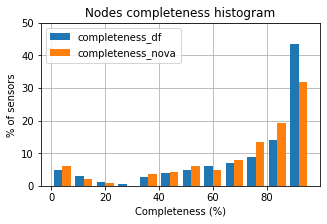

In [9]:
plt.figure(figsize=(5,3))
#plt.subplot(121)
plt.title("Nodes completeness histogram")
plt.xlabel("Completeness (%)")
plt.ylabel("% of sensors")
plt.ylim([0, 50])
aux1=df_comple.completeness_df
aux2=df_comple.completeness_nova
w = [100*np.ones_like(df_comple.index) / len(df_comple.index),100*np.ones_like(df_comple.index) / len(df_comple.index)]
plt.hist([aux1, aux2], bins=12, label=['completeness_df', 'completeness_nova'],weights=w,zorder=3)
plt.legend(loc='upper left')
plt.grid()
plt.savefig('C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/Completeness_2.eps', format='eps',bbox_inches = "tight")


#plt.subplot(122)
#plt.title("nova sensors completeness histogram")
#plt.xlabel("Completeness (%)")
#plt.ylabel("% of sensors")
#plt.ylim([0, 45])
#df_comple.completeness_nova.hist(bins=16,weights = 100*np.ones_like(df_comple.index) / len(df_comple.index),zorder=3)
#plt.savefig('C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/Completeness.eps', format='eps',bbox_inches = "tight")

In [5]:
df_uncer = pd.read_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/df_uncer.csv", header=0)
print(df_uncer.head(2))

   codigoSerial  uncertainty  uncertainty_group
0         220.0    10.614371                NaN
1           1.0    62.981174                NaN


In [10]:
#df_uncer.to_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/df_uncer.csv",index=False)
df_uncer = pd.read_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/df_uncer.csv", header=0)
print(df_uncer.head(2))
print(len(dic_df[1]))
for nodes in dic_df[0]:
    df_uncer.loc[df_uncer.codigoSerial==nodes,"uncertainty"]=np.nan
print(np.count_nonzero(~np.isnan(df_uncer.uncertainty)))

   codigoSerial  uncertainty  uncertainty_group
0         220.0    10.614371                NaN
1           1.0    62.981174                NaN
147
147


UNCERTAINTY

147


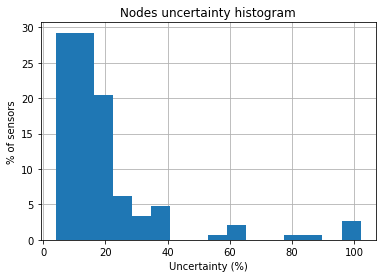

In [11]:
plt.figure(figsize=(6,4))
plt.title("Nodes uncertainty histogram")
plt.xlabel("Uncertainty (%)")
plt.ylabel("% of sensors")
aux=df_uncer.uncertainty.loc[~np.isnan(df_uncer.uncertainty)]
df_uncer.uncertainty.hist(bins=16,weights = 100*np.ones_like(aux.index) / len( aux.index),zorder=3)

print(np.count_nonzero(~np.isnan(df_uncer.uncertainty)))

In [13]:
print(df_uncer.uncertainty.max())

102.02125939177652


147
Nube: 85, Estación: 88, Distancia: 1.511 km
Average error for DF sensor: 234.36506759998258 % and NOVA sensor: 217.38959578814462 %
Nube: 81, Estación: 74, Distancia: 0.5728 km
Average error for DF sensor: nan % and NOVA sensor: nan %


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


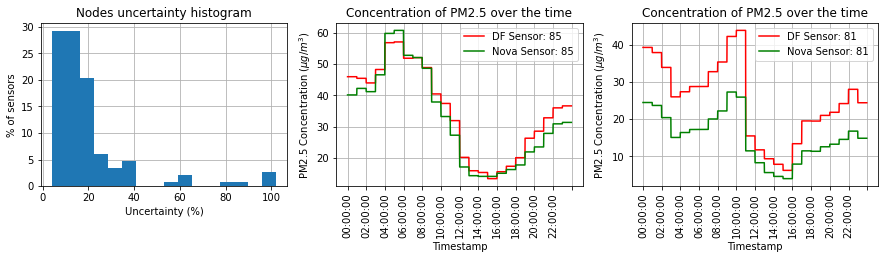

In [216]:

plt.figure(figsize=(15,3))
plt.subplot(131)
plt.title("Nodes uncertainty histogram")
plt.xlabel("Uncertainty (%)")
plt.ylabel("% of sensors")
aux=df_uncer.uncertainty.loc[~np.isnan(df_uncer.uncertainty)]
df_uncer.uncertainty.hist(bins=16,weights = 100*np.ones_like(aux.index) / len( aux.index),zorder=3)

print(np.count_nonzero(~np.isnan(df_uncer.uncertainty)))

nube=85

inicio="2020-02-01 00:00:00"
fin=   "2020-02-01 23:59:00"
CC[nube]["v_pm25"] = np.nan
CC[nube]["alpha_df"] = np.nan
CC[nube]["alpha_nova"] = np.nan
df_window=CC[nube].loc[(CC[nube]['fechaHora'] >= inicio) & (CC[nube]['fechaHora'] <= fin)]
#print(df_window)

#Remove outliers that are out of range, from documentation both nova and df range of measurements are [0,999]
df_window=df_window.copy()
df_window.loc[df_window["pm25_nova"]>999,"pm25_nova"]=np.nan
df_window.loc[df_window["pm25_nova"]<0,"pm25_nova"]=np.nan
df_window.loc[df_window["pm25_df"]>999,"pm25_df"]=np.nan
df_window.loc[df_window["pm25_df"]<0,"pm25_df"]=np.nan

#Remove data above the whiskers of the boxplot
Q1 = df_window['pm25_df'].quantile(0.25)
Q3 = df_window['pm25_df'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
df_window.loc[df_window["pm25_df"]>=Q3 + 1.5 *IQR,"pm25_df"]=np.nan

Q1 = df_window['pm25_nova'].quantile(0.25)
Q3 = df_window['pm25_nova'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
df_window.loc[df_window["pm25_nova"]>=Q3 + 1.5 *IQR,"pm25_nova"]=np.nan

#Moving average filter
#df_window['pm25_nova_lpf'] = df_window.pm25_nova.rolling(window=60,min_periods=1).mean()
#df_window['pm25_df_lpf'] = df_window.pm25_df.rolling(window=60,min_periods=1).mean()

#Hourly mean
df_window['pm25_nova_ave']=np.nan
df_window['pm25_df_ave']=np.nan

#print("Diferentes de nan df: ",np.count_nonzero(~np.isnan(df_window['pm25_df'])))
#print("Diferentes de nan nova: ",np.count_nonzero(~np.isnan(df_window['pm25_nova'])))

for ts in df_window['fechaHora']:
    if ts==ts.ceil('60min'):
        window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < (ts+timedelta(minutes = 1)).ceil('60min'))]
        
    else:
        window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < ts.ceil('60min'))]
    #print("Timestamp: ",ts,", Floor:",ts.floor('60min'),", Ceil:",ts.ceil('60min'),window['pm25_nova'].mean())
    #print(window['pm25_nova'])
    
    df_window.loc[df_window["fechaHora"]==ts,'pm25_nova_ave']=window['pm25_nova'].mean()
    df_window.loc[df_window["fechaHora"]==ts,'pm25_df_ave']=window['pm25_df'].mean()
    #df_window['pm25_nova_ave'][df_window["fechaHora"]==ts]=window['pm25_nova'].mean()
    #df_window['pm25_df_ave'][df_window["fechaHora"]==ts]=window['pm25_df'].mean()
    
    
#del window

Closest_Station=Distances.codigoSerial_ES.loc[nube]
SS[Closest_Station].loc[SS[Closest_Station]["pm25"]<=0,"pm25"]=np.nan
print("Nube: %d, Estación: %d, Distancia: %s km" %(nube, Closest_Station, Distances.Distancia_a_ES.loc[nube]))

for time in df_window.fechaHora:
    idx=SS[Closest_Station].Fecha_Hora.searchsorted(time,side="right")
    #print(idx, SS[Closest_Station].Fecha_Hora.loc[idx], time)
    #v=SS[Closest_Station].pm25.loc[idx]
    v=SS[Closest_Station].loc[idx,"pm25"]
    df_window.loc[df_window.fechaHora == time,"v_pm25"]=v
    #df_window.v_pm25[(df_window.fechaHora == time)]=v
    vm=df_window.loc[(df_window.fechaHora == time),"pm25_df_ave"]
    #print(time," : ",vm.values[0],"________",SS[Closest_Station].Fecha_Hora.loc[idx]," : ",v)
    df_window.loc[df_window.fechaHora == time,"alpha_df"]=100*abs(vm-v)/v
    #df_window.alpha_df[(df_window.fechaHora == time)]=100*abs(vm-v)/v
    vm=df_window.loc[(df_window.fechaHora == time),"pm25_nova_ave"]
    df_window.loc[df_window.fechaHora == time,"alpha_nova"]=100*abs(vm-v)/v
    #df_window.alpha_nova[(df_window.fechaHora == time)]=100*abs(vm-v)/v

print("Average error for DF sensor: %s %% and NOVA sensor: %s %%"%(df_window.alpha_df.mean(),df_window.alpha_nova.mean()))   

#Measurement
plt.subplot(132)
plt.title("Concentration of PM2.5 over the time")
plt.ylabel("PM2.5 Concentration ($μg/m^3$)")
plt.xlabel("Timestamp")
df_window["Time"] = [str(datetime.time(d)) for d in df_window['hora']]
plt.xticks(np.arange(0, len(df_window["Time"])+120, 120), rotation=90)
plt.plot(df_window["Time"],df_window["pm25_df_ave"],"r-",label="DF Sensor: %d"%(nube))
plt.plot(df_window["Time"],df_window["pm25_nova_ave"],"g-",label="Nova Sensor: %d"%(nube))
#plt.plot(df_window["fechaHora"],df_window["v_pm25"],"b-",label="Siata Station: %d"%(Closest_Station))
plt.legend()
plt.grid()

nube=81

inicio="2020-02-01 00:00:00"
fin=   "2020-02-01 23:59:00"
CC[nube]["v_pm25"] = np.nan
CC[nube]["alpha_df"] = np.nan
CC[nube]["alpha_nova"] = np.nan
df_window=CC[nube].loc[(CC[nube]['fechaHora'] >= inicio) & (CC[nube]['fechaHora'] <= fin)]
#print(df_window)

#Remove outliers that are out of range, from documentation both nova and df range of measurements are [0,999]
df_window=df_window.copy()
df_window.loc[df_window["pm25_nova"]>999,"pm25_nova"]=np.nan
df_window.loc[df_window["pm25_nova"]<0,"pm25_nova"]=np.nan
df_window.loc[df_window["pm25_df"]>999,"pm25_df"]=np.nan
df_window.loc[df_window["pm25_df"]<0,"pm25_df"]=np.nan

#Remove data above the whiskers of the boxplot
Q1 = df_window['pm25_df'].quantile(0.25)
Q3 = df_window['pm25_df'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
df_window.loc[df_window["pm25_df"]>=Q3 + 1.5 *IQR,"pm25_df"]=np.nan

Q1 = df_window['pm25_nova'].quantile(0.25)
Q3 = df_window['pm25_nova'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
df_window.loc[df_window["pm25_nova"]>=Q3 + 1.5 *IQR,"pm25_nova"]=np.nan

#Moving average filter
#df_window['pm25_nova_lpf'] = df_window.pm25_nova.rolling(window=60,min_periods=1).mean()
#df_window['pm25_df_lpf'] = df_window.pm25_df.rolling(window=60,min_periods=1).mean()

#Hourly mean
df_window['pm25_nova_ave']=np.nan
df_window['pm25_df_ave']=np.nan

#print("Diferentes de nan df: ",np.count_nonzero(~np.isnan(df_window['pm25_df'])))
#print("Diferentes de nan nova: ",np.count_nonzero(~np.isnan(df_window['pm25_nova'])))

for ts in df_window['fechaHora']:
    if ts==ts.ceil('60min'):
        window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < (ts+timedelta(minutes = 1)).ceil('60min'))]
        
    else:
        window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < ts.ceil('60min'))]
    #print("Timestamp: ",ts,", Floor:",ts.floor('60min'),", Ceil:",ts.ceil('60min'),window['pm25_nova'].mean())
    #print(window['pm25_nova'])
    
    df_window.loc[df_window["fechaHora"]==ts,'pm25_nova_ave']=window['pm25_nova'].mean()
    df_window.loc[df_window["fechaHora"]==ts,'pm25_df_ave']=window['pm25_df'].mean()
    #df_window['pm25_nova_ave'][df_window["fechaHora"]==ts]=window['pm25_nova'].mean()
    #df_window['pm25_df_ave'][df_window["fechaHora"]==ts]=window['pm25_df'].mean()
    
    
del window

Closest_Station=Distances.codigoSerial_ES.loc[nube]
SS[Closest_Station].loc[SS[Closest_Station]["pm25"]<=0,"pm25"]=np.nan
print("Nube: %d, Estación: %d, Distancia: %s km" %(nube, Closest_Station, Distances.Distancia_a_ES.loc[nube]))

for time in df_window.fechaHora:
    idx=SS[Closest_Station].Fecha_Hora.searchsorted(time,side="right")
    #print(idx, SS[Closest_Station].Fecha_Hora.loc[idx], time)
    #v=SS[Closest_Station].pm25.loc[idx]
    v=SS[Closest_Station].loc[idx,"pm25"]
    df_window.loc[df_window.fechaHora == time,"v_pm25"]=v
    #df_window.v_pm25[(df_window.fechaHora == time)]=v
    vm=df_window.loc[(df_window.fechaHora == time),"pm25_df_ave"]
    #print(time," : ",vm.values[0],"________",SS[Closest_Station].Fecha_Hora.loc[idx]," : ",v)
    df_window.loc[df_window.fechaHora == time,"alpha_df"]=100*abs(vm-v)/v
    #df_window.alpha_df[(df_window.fechaHora == time)]=100*abs(vm-v)/v
    vm=df_window.loc[(df_window.fechaHora == time),"pm25_nova_ave"]
    df_window.loc[df_window.fechaHora == time,"alpha_nova"]=100*abs(vm-v)/v
    #df_window.alpha_nova[(df_window.fechaHora == time)]=100*abs(vm-v)/v

print("Average error for DF sensor: %s %% and NOVA sensor: %s %%"%(df_window.alpha_df.mean(),df_window.alpha_nova.mean()))   

#Measurement
plt.subplot(133)
plt.title("Concentration of PM2.5 over the time")
plt.ylabel("PM2.5 Concentration ($μg/m^3$)")
plt.xlabel("Timestamp")
df_window["Time"] = [str(datetime.time(d)) for d in df_window['hora']]
plt.xticks(np.arange(0, len(df_window["Time"])+120, 120), rotation=90)
plt.plot(df_window["Time"],df_window["pm25_df_ave"],"r-",label="DF Sensor: %d"%(nube))
plt.plot(df_window["Time"],df_window["pm25_nova_ave"],"g-",label="Nova Sensor: %d"%(nube))
#plt.plot(df_window["fechaHora"],df_window["v_pm25"],"b-",label="Siata Station: %d"%(Closest_Station))
plt.legend()
plt.grid()
#plt.gcf().subplots_adjust(bottom=0.8)
plt.savefig('C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/Uncertainty.eps', format='eps',bbox_inches = "tight")


PRECISION

In [104]:
print(df_preci.head(2))
print("Number of DF sensors with completeness >75%",len(dic_df[1]))
print("Number of Nova sensors with completeness >75%",len(dic_nova[1]))
for nodes in dic_df[0]:
    df_preci.loc[df_preci.codigoSerial==nodes,"precision_df"]=np.nan
for nodes in dic_nova[0]:
    df_preci.loc[df_preci.codigoSerial==nodes,"precision_nova"]=np.nan
print("Number of DF sensors with completeness >75%",np.count_nonzero(~np.isnan(df_preci.precision_df)))
print("Number of DF sensors with completeness >75%",np.count_nonzero(~np.isnan(df_preci.precision_nova)))

   codigoSerial  precision_df  precision_nova  precision_group_df  \
0         220.0      8.433514        8.012586                 NaN   
1           1.0     11.847854        2.828797                 NaN   

   precision_group_nova  
0                   NaN  
1                   NaN  
Number of DF sensors with completeness >75% 147
Number of Nova sensors with completeness >75% 139
Number of DF sensors with completeness >75% 147
Number of DF sensors with completeness >75% 139


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


139


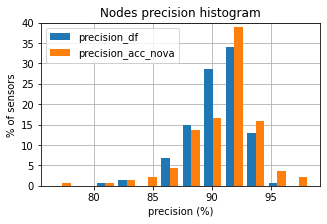

In [206]:
plt.figure(figsize=(5,3))
#plt.subplot(121)
plt.title("Nodes precision histogram")
plt.xlabel("precision (%)")
plt.ylabel("% of sensors")
plt.ylim([0, 40])
df_preci_comp=100-df_preci.precision_df
aux1=df_preci_comp.loc[~np.isnan(df_preci_comp)]
df_preci_comp=100-df_preci.precision_nova
aux2=df_preci_comp.loc[~np.isnan(df_preci_comp)]
w = [100*np.ones_like(aux1.index) / len(aux1.index),100*np.ones_like(aux2.index) / len(aux2.index)]
#df_preci_comp.hist(bins=16,weights = 100*np.ones_like(aux.index) / len( aux.index),zorder=3)
plt.hist([aux1, aux2], bins=12, label=['precision_df', 'precision_acc_nova'],weights=w,zorder=3)
plt.legend(loc='upper left')
plt.grid()
plt.savefig('C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/Precision_2.eps', format='eps',bbox_inches = "tight")







print(np.count_nonzero(~np.isnan(df_preci_comp)))




#plt.subplot(122)
#plt.title("nova sensors precision histogram")
#plt.xlabel("precision (%)")
#plt.ylabel("% of sensors")
#plt.ylim([0, 35])
#df_preci_comp=100-df_preci.precision_nova
#aux=df_preci_comp.loc[~np.isnan(df_preci_comp)]
#df_preci_comp.hist(bins=16,weights = 100*np.ones_like(aux.index) / len( aux.index),zorder=3)
#plt.savefig('C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/Precision.eps', format='eps',bbox_inches = "tight")


In [223]:
(100-df_preci.precision_nova).median()

91.53651928894556

ACCURACY

In [117]:
print(df_accur.head(2))
print("Number of DF sensors with completeness >75%",len(dic_df[1]))
print("Number of Nova sensors with completeness >75%",len(dic_nova[1]))
for nodes in dic_df[0]:
    df_accur.loc[df_accur.codigoSerial==nodes,"acc_df"]=np.nan
for nodes in dic_nova[0]:
    df_accur.loc[df_accur.codigoSerial==nodes,"acc_nova"]=np.nan
print("Number of DF sensors with completeness >75%",np.count_nonzero(~np.isnan(df_accur.acc_df)))
print("Number of Nova sensors with completeness >75%",np.count_nonzero(~np.isnan(df_accur.acc_nova)))

   codigoSerial      dist   acc_nova     acc_df  34.479689
0         220.0  1.507812        NaN        NaN        NaN
1           1.0  1.036133  60.244317  37.238393        NaN
Number of DF sensors with completeness >75% 147
Number of Nova sensors with completeness >75% 139
Number of DF sensors with completeness >75% 107
Number of Nova sensors with completeness >75% 103


Number of sensors 110
Number of sensors 102
Number of sensors 107


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


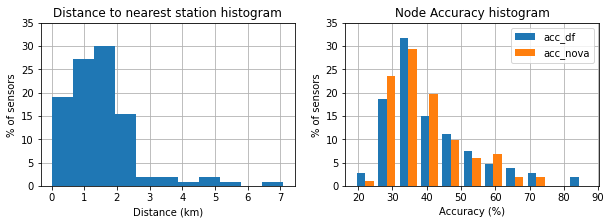

In [207]:
#
plt.figure(figsize=(10,3))

plt.subplot(121)
plt.title("Distance to nearest station histogram")
plt.xlabel("Distance (km)")
plt.ylabel("% of sensors")
plt.ylim([0, 35])
aux=df_accur.loc[~np.isnan(df_accur['acc_nova'])| ~np.isnan(df_accur['acc_df']),"dist"]
aux.hist(bins=11,weights=100*np.ones_like(aux.index) / len(aux.index),zorder=3)
ndatos_dist=np.size(df_accur.loc[(~np.isnan(df_accur['acc_nova'])| ~np.isnan(df_accur['acc_df'])),"dist"])

print("Number of sensors",ndatos_dist)
ndatos_dist=np.size(df_accur.loc[(~np.isnan(df_accur['acc_nova'])),"dist"])
print("Number of sensors",ndatos_dist)
ndatos_dist=np.size(df_accur.loc[( ~np.isnan(df_accur['acc_df'])),"dist"])
print("Number of sensors",ndatos_dist)

plt.subplot(122)
plt.title("Node Accuracy histogram")
plt.xlabel("Accuracy (%)")
plt.ylabel("% of sensors")
plt.ylim([0, 35])
#plt.xlim([0, 1300])

aux1=df_accur.acc_df.loc[~np.isnan(df_accur.acc_df)]
aux2=df_accur.acc_nova.loc[~np.isnan(df_accur.acc_nova)]
w = [100*np.ones_like(aux1.index) / len(aux1.index),100*np.ones_like(aux2.index) / len(aux2.index)]
plt.hist([aux1, aux2], bins=11, label=['acc_df', 'acc_nova'],weights=w,zorder=3)
plt.legend(loc='upper right')
plt.grid()
plt.savefig('C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/Accuracy_2.eps', format='eps',bbox_inches = "tight")



#plt.subplot(132)
#plt.title("df sensors Accuracy histogram")
#plt.xlabel("Accuracy (%)")
#plt.ylabel("% of sensors")
#plt.ylim([0, 35])
##plt.xlim([0, 1300])
#aux=df_accur.acc_df.loc[~np.isnan(df_accur.acc_df)]
#print(np.size(aux))
#df_accur.acc_df.hist(bins=11,weights = 100*np.ones_like(aux.index) / len(aux.index),zorder=3)
#
#plt.subplot(133)
#plt.title("nova sensors Accuracy histogram")
#plt.xlabel("Accuracy (%)")
#plt.ylabel("% of sensors")
#plt.ylim([0, 35])
##plt.xlim([0, 1300])
#aux=df_accur.acc_nova.loc[~np.isnan(df_accur.acc_nova)]
#print(np.size(aux))
#df_accur.acc_nova.hist(bins=11,weights = 100*np.ones_like(aux.index) / len(aux.index),zorder=3)
#plt.savefig('C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/Accuracy.eps', format='eps',bbox_inches = "tight")


In [128]:
df_accur.head(60)
df_accur.loc[df_accur.acc_nova>400,"acc_nova"]=np.nan
df_accur.acc_nova.max()

74.54746599840026

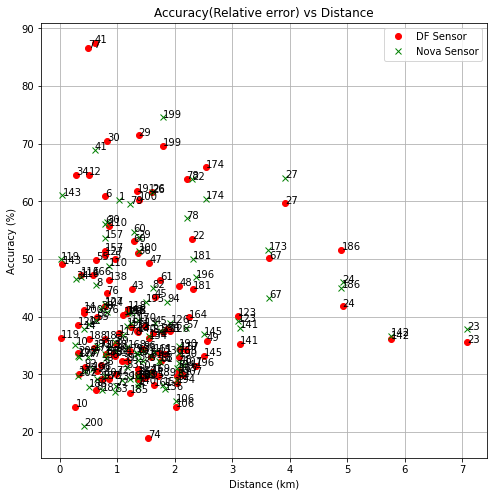

In [144]:
plt.figure(figsize=(8,8))

plt.title("Accuracy(Relative error) vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Accuracy (%)")
#df_accur["acc_nova_2"]=df_accur["acc_nova"]
#df_accur["acc_df_2"]=df_accur["acc_df"]
#df_accur

df_accur.loc[df_accur["acc_nova"]==np.inf,"acc_nova"]=np.nan
df_accur.loc[df_accur["acc_df"]==np.inf,"acc_df"]=np.nan

plt.plot(df_accur["dist"],df_accur["acc_df"],'ro',label="DF Sensor")

for i in df_accur.index:
    if not np.isnan(df_accur["acc_df"].loc[i]):
        plt.text(df_accur["dist"].loc[i],df_accur["acc_df"].loc[i],i)
        
plt.plot(df_accur["dist"],df_accur["acc_nova"],'gx',label="Nova Sensor")

for i in df_accur.index:
    if not np.isnan(df_accur["acc_nova"].loc[i]):
        plt.text(df_accur["dist"].loc[i],df_accur["acc_nova"].loc[i],i)

plt.legend()
plt.grid()

CORRELATION

In [147]:
print(df_conco.head(2))
print("Number of DF sensors with completeness >75%",len(dic_df[1]))
print("Number of Nova sensors with completeness >75%",len(dic_nova[1]))
for nodes in dic_df[0]:
    df_conco.loc[df_conco.codigoSerial==nodes,["concordance_df_nova","concordance_df_siata","concordance_df_hum","concordance_df_temp"]]=np.nan
    
for nodes in dic_nova[0]:
    df_conco.loc[df_conco.codigoSerial==nodes,["concordance_df_nova","concordance_nova_siata","concordance_nova_hum","concordance_nova_temp"]]=np.nan
print("Number of DF sensors with completeness >75%",np.count_nonzero(~np.isnan(df_conco.concordance_df_siata)))
print("Number of Nova sensors with completeness >75%",np.count_nonzero(~np.isnan(df_conco.concordance_nova_siata)))

   codigoSerial  concordance_df_nova  concordance_df_siata  \
0         220.0             0.910206              0.278495   
1           1.0             0.931952              0.006428   

   concordance_df_hum  concordance_df_temp  concordance_nova_siata  \
0            0.037528             0.037533                0.251822   
1            0.539485             0.402828                0.027979   

   concordance_nova_hum  concordance_nova_temp  
0              0.015911               0.015917  
1              0.647615               0.499153  
Number of DF sensors with completeness >75% 147
Number of Nova sensors with completeness >75% 139
Number of DF sensors with completeness >75% 107
Number of Nova sensors with completeness >75% 103


135


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


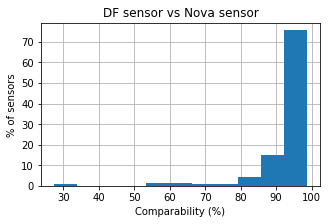

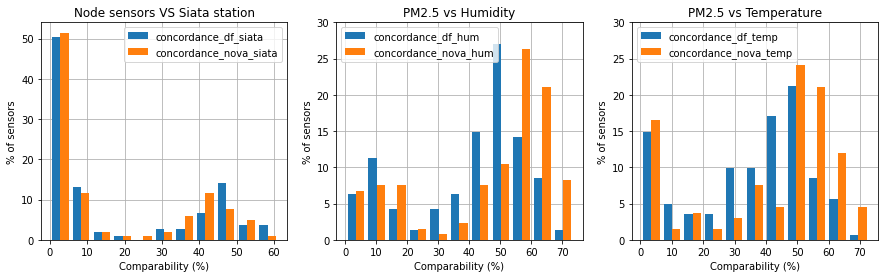

In [225]:

plt.figure(figsize=(5,3))
plt.title("DF sensor vs Nova sensor")
plt.xlabel("Comparability (%)")
plt.ylabel("% of sensors")
aux=100*df_conco.concordance_df_nova.loc[~np.isnan(df_conco.concordance_df_nova)]
print(np.size(aux))
aux.hist(bins=11,weights = 100*np.ones_like(aux.index) / len(aux.index),zorder=3)
plt.savefig('C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/Concordance_DF_NOVA.eps', format='eps',bbox_inches = "tight")



plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title("Node sensors VS Siata station")
plt.xlabel("Comparability (%)")
plt.ylabel("% of sensors")
aux1=100*df_conco.concordance_df_siata.loc[~np.isnan(df_conco.concordance_df_siata)]
aux2=100*df_conco.concordance_nova_siata.loc[~np.isnan(df_conco.concordance_nova_siata)]
w = [100*np.ones_like(aux1.index) / len(aux1.index),100*np.ones_like(aux2.index) / len(aux2.index)]
plt.hist([aux1, aux2], bins=11, label=['concordance_df_siata', 'concordance_nova_siata'],weights=w,zorder=3)
plt.legend(loc='upper right')
plt.grid()

plt.subplot(132)
plt.title("PM2.5 vs Humidity")
plt.xlabel("Comparability (%)")
plt.ylabel("% of sensors")
plt.ylim([0, 30])
aux1=100*df_conco.concordance_df_hum.loc[~np.isnan(df_conco.concordance_df_hum)]
aux2=100*df_conco.concordance_nova_hum.loc[~np.isnan(df_conco.concordance_nova_hum)]
w = [100*np.ones_like(aux1.index) / len(aux1.index),100*np.ones_like(aux2.index) / len(aux2.index)]
plt.hist([aux1, aux2], bins=11, label=['concordance_df_hum', 'concordance_nova_hum'],weights=w,zorder=3)
plt.legend(loc='upper left')
plt.grid()

plt.subplot(133)
plt.title("PM2.5 vs Temperature")
plt.xlabel("Comparability (%)")
plt.ylabel("% of sensors")
plt.ylim([0, 30])
aux1=100*df_conco.concordance_df_temp.loc[~np.isnan(df_conco.concordance_df_temp)]
aux2=100*df_conco.concordance_nova_temp.loc[~np.isnan(df_conco.concordance_nova_temp)]
w = [100*np.ones_like(aux1.index) / len(aux1.index),100*np.ones_like(aux2.index) / len(aux2.index)]
plt.hist([aux1, aux2], bins=11, label=['concordance_df_temp', 'concordance_nova_temp'],weights=w,zorder=3)
plt.legend(loc='upper left')
plt.grid()
plt.savefig('C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/Concordance_OtherVariables.eps', format='eps',bbox_inches = "tight")



Testing with parallelitation

In [ ]:
def parse_file(filename):
    ...

def main():
    pool = mp.Pool(processes=6)
    pool.map(parse_file, ['my_dir/' + filename for filename in os.listdir("my_dir")])

if __name__ == '__main__':
    main()

Import Setup file format

In [40]:
## Weights
mu                =0.9
Accuracy          =0.20
Precision         =0.07
Confidence        =0.16
Completeness      =0.10
Timeliness        =0.12
Data_Volume       =0.16
Data_Redundancy   =0.02
Concordance       =0.16

Utility           =0.12
Accessibility     =0.16
Interpretability  =0.28
Reputation        =0.12
Artificiality     =0.20
Access_Security   =0.12


#Period
inicio="2020-02-03 00:00:00"
fin   ="2020-02-03 23:59:00"
start_time ="2020-02-10 00:00:00"
end_time   ="2020-02-11 23:59:00"

#Variable Inicialization
nube=0
node=220
contador=0
counter=0

Allow the user to select a file using the function: get_path('*.csv')

In [3]:

def get_path(wildcard, title):
    app = wx.App(None)
    style = wx.FD_OPEN | wx.FD_FILE_MUST_EXIST
    dialog = wx.FileDialog(None, title, wildcard=wildcard, style=style)
    if dialog.ShowModal() == wx.ID_OK:
        path = dialog.GetPath()
    else:
        path = None
    dialog.Destroy()
    return path
#filepath=get_path('*.csv',"This is the title")
#print (filepath,type(filepath))


READ DATA

In [4]:
#Read Data from February
header_CC=["codigoSerial", "fecha", "hora", "fechaHora", "temperatura", "humedad_relativa", "pm1_df", "pm10_df", "pm25_df", "pm1_nova", "pm10_nova", "pm25_nova", "calidad_temperatura", "calidad_humedad_relativa", "calidad_pm1_df", "calidad_pm10_df", "calidad_pm25_df", "calidad_pm1_nova", "calidad_pm10_nova", "calidad_pm25_nova"]
datatypes_CC={"codigoSerial":np.uint16, "temperatura":np.float16, "humedad_relativa":np.float16, "pm1_df":np.float32, "pm10_df":np.float32, "pm25_df":np.float32, "pm1_nova":np.float32, "pm10_nova":np.float32, "pm25_nova":np.float32}

path_for_CC_data=get_path('*.csv',"Select Citizen Scientist *.csv file")
try:
    df_CC = pd.read_csv(path_for_CC_data, header=None, names=header_CC, usecols=header_CC , dtype=datatypes_CC,parse_dates=["fecha","hora","fechaHora"])
    print("Source path for Citizen Science nodes data: ",path_for_CC_data)

    #Data includes January, February and March
    header_SS=["Fecha_Hora","codigoSerial","pm25","calidad_pm25","pm10","calidad_pm10"]
    datatypes_SS={"codigoSerial":np.uint16,"pm25":np.float32,"pm10":np.float32}
    path_for_SS_data=get_path('*.csv',"Select SIATA Stations *.csv file")
    df_SS = pd.read_csv(path_for_SS_data, header=None,names=header_SS, usecols=header_SS , dtype=datatypes_SS,parse_dates=["Fecha_Hora"])
    print("Source path for Siata Stations data: ",path_for_SS_data)
    
    grouped=df_CC.groupby(df_CC.codigoSerial)
    CC={}
    print("Citizen Scientist: ", sorted(list(df_CC.codigoSerial.unique())))
    for i in df_CC.codigoSerial.unique():
        CC[i] = grouped.get_group(i).sort_values(by=['fechaHora'],ignore_index=True)
    del df_CC
    
    grouped=df_SS.groupby(df_SS.codigoSerial)
    SS={}
    print("Siata Stations: ", list(df_SS.codigoSerial.unique()))
    for j in df_SS.codigoSerial.unique():
        SS[j] = grouped.get_group(j).sort_values(by=['Fecha_Hora'],ignore_index=True)
    del df_SS
    del grouped
except:
    print("An exception occurred, it is possible that wrong files were chosen, please run again")

Source path for Citizen Science nodes data:  C:\Users\julio\Documents\UDEA\Maestría\DQ in IOT\Datasets\SIATA_CS\SplitDatosCC\Samples\February.csv
Source path for Siata Stations data:  C:\Users\julio\Documents\UDEA\Maestría\DQ in IOT\Datasets\SIATA Stations\PM\SS_PM.csv
Citizen Scientist:  [1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 99, 100, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152, 153, 154, 156, 157, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 184, 185

Function for Data cleaning

In [41]:
def clean_data(node, CC, start_time, end_time):
    
    #define a time windows of the data to be analyzed/cleaned
    df_window=CC[node][(CC[node]['fechaHora'] >= start_time) & (CC[node]['fechaHora'] <= end_time)]
    #Remove outliers that are out of range, from documentation both nova and df range of measurements are [0,999]
    df_window=df_window.copy()
    df_window.loc[df_window["pm25_nova"]>999,"pm25_nova"]=np.nan
    df_window.loc[df_window["pm25_nova"]<0,"pm25_nova"]=np.nan
    df_window.loc[df_window["pm25_df"]>999,"pm25_df"]=np.nan
    df_window.loc[df_window["pm25_df"]<0,"pm25_df"]=np.nan
    
    #Remove data above the whiskers of the boxplot: i.e. anomaly data
    Q1 = df_window['pm25_df'].quantile(0.25)
    Q3 = df_window['pm25_df'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 
    df_window.loc[df_window["pm25_df"]>=Q3 + 1.5 *IQR,"pm25_df"]=np.nan
    
    Q1 = df_window['pm25_nova'].quantile(0.25)
    Q3 = df_window['pm25_nova'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 
    df_window.loc[df_window["pm25_nova"]>=Q3 + 1.5 *IQR,"pm25_nova"]=np.nan
    
    return df_window
#df_window_after=clean_data(node, CC, start_time, end_time)



Function for Precision Calulation

In [6]:

def precision(node, df_window):
    #Hourly standard deviation
    df_window['pm25_nova_pre']=np.nan
    df_window['pm25_df_pre']=np.nan
    for ts in df_window['fechaHora']:
        if ts==ts.ceil('60min'):
            window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < (ts+timedelta(minutes = 1)).ceil('60min'))]# Next ONE HOUR WINDOW
            
        else:
            window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < ts.ceil('60min'))]#Current ONE HOUR window
        #print("Timestamp: ",ts,", Floor:",ts.floor('60min'),", Ceil:",ts.ceil('60min'),window['pm25_nova'].mean())
        #print(window['pm25_nova'])        
        df_window.loc[df_window["fechaHora"]==ts,'pm25_nova_pre']=1-(window['pm25_nova'].std()/window['pm25_nova'].mean())# 1-Coefficient of Variation (std/mean)
        df_window.loc[df_window["fechaHora"]==ts,'pm25_df_pre']=1-(window['pm25_df'].std()/window['pm25_df'].mean())# 1-Coefficient of Variation (std/mean)
        
    del window
    prec_df=df_window.pm25_df_pre.mean()#Average precision of the whole node for DF
    prec_nova=df_window.pm25_nova_pre.mean()  #Average precision of the whole node for NOVA  
    preci_dict={"codigoSerial":node,"precision_df":prec_df,"precision_nova":prec_nova}
    #print("%d. Nube: %d, Overall relative (Precision) Standard Deviation."%(contador,nube))
    del prec_df
    del prec_nova
    return preci_dict


#df_preci=df_preci.append(precision(node, df_window), ignore_index = True)
#df_preci.to_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/df_preci.csv",index=False)


Function for Uncertainty calculation

In [12]:
def uncertainty(node, df_window):
    #Hourly standard deviation
    df_window['pm25_nova_pre']=np.nan
    df_window['pm25_df_pre']=np.nan
    for ts in df_window['fechaHora']:
        if ts==ts.ceil('60min'):
            window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < (ts+timedelta(minutes = 1)).ceil('60min'))]# Next ONE HOUR WINDOW
            
        else:
            window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < ts.ceil('60min'))]#Current ONE HOUR window
        #print("Timestamp: ",ts,", Floor:",ts.floor('60min'),", Ceil:",ts.ceil('60min'),window['pm25_nova'].mean())
        #print(window['pm25_nova'])        
        df_window.loc[df_window["fechaHora"]==ts,'pm25_unc']=\
        1-np.sqrt((window.pm25_df-window.pm25_nova).pow(2).mean()/2)/((window.pm25_df+window.pm25_nova).mean()/2)
        
    del window
    
    uncer_df=df_window.pm25_unc.mean()#Average uncertainty of the whole node
    uncer_dict={"codigoSerial":node,"uncertainty":uncer_df}
    del uncer_df
    
    return uncer_dict


#df_preci=df_preci.append(precision(node, df_window), ignore_index = True)
#df_preci.to_csv("C:/Users/julio/Documents/UDEA/Maestría/DQ in IOT/Datasets/DQ_February/df_preci.csv",index=False)


Function to evaluate Accuracy

In [75]:
def accuracy(node, df_window):
    #Hourly mean
    df_window['pm25_nova_ave']=np.nan
    df_window['pm25_df_ave']=np.nan    
    
    for ts in df_window['fechaHora']:
        if ts==ts.ceil('60min'):
            window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < (ts+timedelta(minutes = 1)).ceil('60min'))]# Next ONE HOUR WINDOW
            
        else:
            window=df_window[(df_window['fechaHora'] >= ts.floor('60min')) & (df_window['fechaHora'] < ts.ceil('60min'))]#Current ONE HOUR window
        #print("Timestamp: ",ts,", Floor:",ts.floor('60min'),", Ceil:",ts.ceil('60min'),window['pm25_nova'].mean())
        #print(window['pm25_nova'])        
        df_window.loc[df_window["fechaHora"]==ts,'pm25_nova_ave']=window['pm25_nova'].mean()
        df_window.loc[df_window["fechaHora"]==ts,'pm25_df_ave']=window['pm25_df'].mean()

    Closest_Station=Distances.codigoSerial_ES.loc[node]    
    Closest_Station2=Distances.codigoSerial_ES2.loc[node] 
    if Closest_Station in SS.keys():
        #Clean values out of range
        SS[Closest_Station].loc[SS[Closest_Station]["pm25"]<=0,"pm25"]=np.nan
        for time in df_window.fechaHora:
            
            idx=SS[Closest_Station].Fecha_Hora.searchsorted(time,side="right")
            #print(idx, SS[Closest_Station].Fecha_Hora.loc[idx], time)
            v=SS[Closest_Station].loc[idx,"pm25"]
            df_window.loc[df_window.fechaHora == time,"v_pm25"]=v
            vm=df_window.loc[(df_window.fechaHora == time),"pm25_df_ave"]
            #print(time," : ",vm.values[0],"________",SS[Closest_Station].Fecha_Hora.loc[idx]," : ",v)
            #print(v,"<->", vm.values[0])
            df_window.loc[df_window.fechaHora == time,"alpha_df"]=  max(0,1-abs(vm.values[0]-v)/v)
            vm=df_window.loc[(df_window.fechaHora == time),"pm25_nova_ave"]
            df_window.loc[df_window.fechaHora == time,"alpha_nova"]=max(0,1-abs(vm.values[0]-v)/v)
        
        accu_dict={'codigoSerial':node, 'dist':Distances.loc[node,"Distancia_a_ES"], 'acc_df':df_window.alpha_df.mean(), 'acc_nova':df_window.alpha_nova.mean()}
    
    elif Closest_Station2 in SS.keys():
        #Clean values out of range
        SS[Closest_Station2].loc[SS[Closest_Station2]["pm25"]<=0,"pm25"]=np.nan
        for time in df_window.fechaHora:
            
            idx=SS[Closest_Station2].Fecha_Hora.searchsorted(time,side="right")
            #print(idx, SS[Closest_Station].Fecha_Hora.loc[idx], time)
            v=SS[Closest_Station2].loc[idx,"pm25"]
            df_window.loc[df_window.fechaHora == time,"v_pm25"]=v
            vm=df_window.loc[(df_window.fechaHora == time),"pm25_df_ave"]
            #print(time," : ",vm.values[0],"________",SS[Closest_Station].Fecha_Hora.loc[idx]," : ",v)
            #print(v, vm)
            df_window.loc[df_window.fechaHora == time,"alpha_df"]=  max(0,1-abs(vm.values[0]-v)/v)
            vm=df_window.loc[(df_window.fechaHora == time),"pm25_nova_ave"]
            df_window.loc[df_window.fechaHora == time,"alpha_nova"]=max(0,1-abs(vm.values[0]-v)/v)
        
        accu_dict={'codigoSerial':node, 'dist':Distances.loc[node,"Distancia_a_ES"], 'acc_df':df_window.alpha_df.mean(), 'acc_nova':df_window.alpha_nova.mean()}
        
    else:
        accu_dict={'codigoSerial':node, 'dist':np.nan, 'acc_df':np.nan, 'acc_nova':np.nan}
    return accu_dict

Function to evaluate concordance

In [50]:
def concordance(node, df_window):
    
    Closest_Station=Distances.codigoSerial_ES.loc[node]    
    if Closest_Station in SS.keys():
        #Clean values out of range
        SS[Closest_Station].loc[SS[Closest_Station]["pm25"]<=0,"pm25"]=np.nan
        for time in df_window.fechaHora:
            
            idx=SS[Closest_Station].Fecha_Hora.searchsorted(time,side="right")
            #print(idx, SS[Closest_Station].Fecha_Hora.loc[idx], time)
            v=SS[Closest_Station].loc[idx,"pm25"]
            df_window.loc[df_window.fechaHora == time,"v_pm25"]=v
   
    #Comparability / Concordance
    corr_df = df_window.loc[:,["pm25_df","pm25_nova","v_pm25","temperatura","humedad_relativa"]].corr().iloc[0].abs()
    corr_nova = df_window.loc[:,["pm25_df","pm25_nova","v_pm25","temperatura","humedad_relativa"]].corr().iloc[1].abs()
    conco_dict={"codigoSerial":node,"concordance_df_nova":corr_df.pm25_nova,
                "concordance_df_siata":corr_df.v_pm25,"concordance_df_hum":corr_df.humedad_relativa,"concordance_df_temp":corr_df.temperatura,
                "concordance_nova_siata":corr_nova.v_pm25,"concordance_nova_hum":corr_nova.humedad_relativa,"concordance_nova_temp":corr_nova.temperatura}
    return conco_dict
    

In [77]:
node=100
df_window=clean_data(node, CC, start_time, end_time)
#df_preci = pd.DataFrame(columns =["codigoSerial","precision_df","precision_nova",])
#df_uncer = pd.DataFrame(columns =["codigoSerial","uncertainty","uncertainty_group"])
#df_conco = pd.DataFrame(columns =["codigoSerial","concordance_df_nova","concordance_df_siata","concordance_df_hum","concordance_df_temp","concordance_nova_siata","concordance_nova_hum","concordance_nova_temp"])
#df_accur = pd.DataFrame(columns =['codigoSerial', 'dist', 'acc_nova', 'acc_df'])


df_accur=df_accur.append(accuracy(node, df_window), ignore_index = True)
df_accur

,codigoSerial,dist,acc_nova,acc_df
0,1.0,1.036133,64.537881,21.968847
1,10.0,1.582031,29.018977,28.856827
2,100.0,1.014648,22.232653,22.614731
3,200.0,2.367188,46.221728,22.368050
4,2.0,2.208984,36.396503,28.177656
5,20.0,1.824219,NaN,NaN
6,200.0,2.367188,46.221728,22.368050
7,200.0,2.367188,46.221728,22.368050
8,1.0,1.036133,64.537881,21.968847
9,1.0,1.036133,0.354621,0.780312


In [ ]:
acc_vs_dis=[]
missing_data_df=[]
missing_data_nova=[]

df_accur = pd.DataFrame(columns =['codigoSerial', 'dist', 'acc_nova', 'acc_df'])
df_comple = pd.DataFrame(columns =["codigoSerial","completeness_df","completeness_nova"])
df_preci = pd.DataFrame(columns =["codigoSerial","precision_df","precision_nova",])
df_uncer = pd.DataFrame(columns =["codigoSerial","uncertainty"])
df_conco = pd.DataFrame(columns =["codigoSerial","concordance_df_nova","concordance_df_siata","concordance_df_hum","concordance_df_temp","concordance_nova_siata","concordance_nova_hum","concordance_nova_temp"])


for nube in CC.keys():
    contador+=1
    CC[nube]["v_pm25"] = np.nan
    CC[nube]["alpha_df"] = np.nan
    CC[nube]["alpha_nova"] = np.nan
    #del df_window
    
    df_window=clean_data(nube, CC, start_time, end_time)
        
    ref_date_range = pd.date_range(inicio, fin, freq='1Min')
    ref_date_range = pd.DataFrame(ref_date_range,columns=["ref_fechaHora"])
    
    
    
    #PRECISION
    df_preci=df_preci.append(precision(nube, df_window), ignore_index = True)
    print("%d. Nube: %d, Overall relative (Precision) Standard Deviation."%(contador,nube))
    
    #UNCERTAINTY
    df_uncer=df_uncer.append(uncertainty(nube, df_window), ignore_index = True)
    print("%d. Nube: %d, Overall relative Uncertainty BS, "%(contador,nube))
    
    #ACCURACY

    df_accur=df_accur.append(accuracy(nube, df_window), ignore_index = True)
    print("%d. Nube: %d, Accuracy," %(contador, nube))
    
    
    #COMPLETENESS
    #ref_date_range = pd.date_range(inicio, fin, freq='1Min')
    #ref_date_range = pd.DataFrame(ref_date_range,columns=["ref_fechaHora"])
    ref_date_range = pd.DataFrame(pd.date_range(inicio, fin, freq='1Min'),columns=["ref_fechaHora"])

    #Check for any missing date
    missing_dates = ref_date_range.loc[~ref_date_range.ref_fechaHora.isin(df_window.fechaHora),"ref_fechaHora"]

    #Add missing date rows
    for missing in missing_dates:
        df_window=df_window.append({"codigoSerial":nube,"fechaHora":missing}, ignore_index = True)
    
    #Check for any missing date
    missing_dates = ref_date_range.loc[~ref_date_range.ref_fechaHora.isin(df_window.fechaHora),"ref_fechaHora"]
    
    #Check for missing data
    missing_data_df=np.count_nonzero(np.isnan(df_window['pm25_df']))
    missing_data_nova=np.count_nonzero(np.isnan(df_window['pm25_nova']))
    comp_df=(1-missing_data_df/np.size(df_window.pm25_df))
    comp_nova=(1-missing_data_nova/np.size(df_window.pm25_nova))
    
    
       
    df_comple=df_comple.append({"codigoSerial":nube,"completeness_df":comp_df,"completeness_nova":comp_nova}, ignore_index = True)
    
    print("%d. Nube: %d, Completeness." %(contador,nube))
    #Comparability / Concordance
    corr_df = df_window.loc[:,["pm25_df","pm25_nova","v_pm25","temperatura","humedad_relativa"]].corr().iloc[0].abs()
    corr_nova = df_window.loc[:,["pm25_df","pm25_nova","v_pm25","temperatura","humedad_relativa"]].corr().iloc[1].abs()
  
    
        
    df_conco=df_conco.append(concordance(nube,df_windows),ignore_index = True)
    
    print("%d. Nube: %d, Overall concordance, "%(contador,nube))

In [86]:
#TEST CODE TO PLAY WITH STRINGS AND TIMESTAMPS FORMATS
from datetime import datetime
inicio="2020-02-03 10:59:00"
datetime_str = inicio

ts = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

ts=pd.Timestamp(datetime_str).floor('60min')

ts

Timestamp('2020-02-03 10:00:00')